In [1]:
import os
import numpy as np

def load_all_updates(data_dirs):
    updates = []
    for run_dir in data_dirs:
        run_dir = "./dagmm_train_data/" + run_dir
        for fname in os.listdir(run_dir):
            if fname.endswith(".npy"):
                path = os.path.join(run_dir, fname)
                update = np.load(path)
                updates.append(update)
    return np.stack(updates)

# Example:
data_dirs = ["run_" + str(x) for x in range(1,10)]
X = load_all_updates(data_dirs)  # shape: (n_samples, n_features)
VAL = load_all_updates(["run_val", "run_val_1"])

In [2]:
X_train = X
X_test = VAL

input_dim = X_train.shape[1]
print("Input dim: ", input_dim)
print("Number of training data: ", len(X_train))

print("Number of validation data: ", len(X_test))

Input dim:  62006
Number of training data:  3092
Number of validation data:  344


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)

Adapted from [github](https://github.com/danieltan07/dagmm/)

In [5]:
from dagmm import DAGMM

In [6]:
def train_dagmm(model, dataloader, num_epochs, lr=0.0001, lambda_energy=0.1, lambda_cov_diag=0.005, grad_clip_norm=1.0, device='cuda'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for batch in dataloader:
            x = batch[0].to(device)
            enc, x_hat, z, gamma = model(x)

            loss, sample_energy, recon_error, cov_diag = model.loss_function(
                x, x_hat, z, gamma, lambda_energy, lambda_cov_diag
            )

            optimizer.zero_grad()
            loss.backward()
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Energy: {sample_energy:.4f}, Recon: {recon_error:.4f}, CovDiag: {cov_diag:.4f}")

In [21]:
dagmm_model = DAGMM(input_dim)
train_dagmm(dagmm_model, train_loader, 100)

Epoch 1/100, Loss: -127.2668, Energy: -65.5021, Recon: 0.0067, CovDiag: 0.9142
Epoch 2/100, Loss: -156.3272, Energy: -77.4329, Recon: 0.0122, CovDiag: 0.6465
Epoch 3/100, Loss: -187.8941, Energy: -84.1695, Recon: 0.0195, CovDiag: 0.7261
Epoch 4/100, Loss: -210.4682, Energy: -93.4819, Recon: 0.0297, CovDiag: 1.6997
Epoch 5/100, Loss: -226.6376, Energy: -96.4353, Recon: 0.0386, CovDiag: 5.9821
Epoch 6/100, Loss: -236.9957, Energy: -97.3948, Recon: 0.0504, CovDiag: 12.5778
Epoch 7/100, Loss: -240.9653, Energy: -98.4084, Recon: 0.0698, CovDiag: 3.8862
Epoch 8/100, Loss: -243.5460, Energy: -98.9380, Recon: 0.0701, CovDiag: 7.7597
Epoch 9/100, Loss: -243.9365, Energy: -98.9513, Recon: 0.0609, CovDiag: 6.9767
Epoch 10/100, Loss: -245.0282, Energy: -98.9817, Recon: 0.0554, CovDiag: 6.4726
Epoch 11/100, Loss: -245.5092, Energy: -99.4809, Recon: 0.0457, CovDiag: 8.0639
Epoch 12/100, Loss: -244.3748, Energy: -98.6180, Recon: 0.0483, CovDiag: 5.2680
Epoch 13/100, Loss: -245.0894, Energy: -99.8162,

In [39]:
torch.save(dagmm_model.state_dict(), "dagmm_model.pt")

In [8]:
def compute_sample_energy(model, z):
    sample_energy, _ = model.compute_energy(z, size_average=False)
    return sample_energy

In [9]:
def get_energy_scores(model, data_tensor, batch_size=128):
    model.eval()
    energies = []
    gammas = []

    with torch.no_grad():
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i:i+batch_size].to(device)
            _, _, z, gamma = model(batch)
            gammas.append(gamma.to("cpu"))
            energy = compute_sample_energy(model, z)
            energies.append(energy.to("cpu"))

    return torch.cat(energies).numpy(), torch.cat(gammas).numpy()

In [22]:
sample_real = X_test[0]
tensor_real = torch.tensor(sample_real, dtype=torch.float32).unsqueeze(0)

tensor_random = (torch.rand_like(tensor_real) * 2 - 1 ) * 1e-3

combined_samples_tensor = torch.cat([tensor_real, tensor_random], dim=0).to(device)
energies, gammas = get_energy_scores(dagmm_model, combined_samples_tensor, batch_size=2)
print(f"Real Sample (X_test[0]): energy: {energies[0]:.4f}, gamma: {gammas[0]}")
print(f"Random Sample:           {energies[1]:.4f}, gamma: {gammas[1]}")

Real Sample (X_test[0]): energy: 669.9700, gamma: [0.2275482 0.7724518]
Random Sample:           9064.7061, gamma: [0.22819582 0.7718042 ]


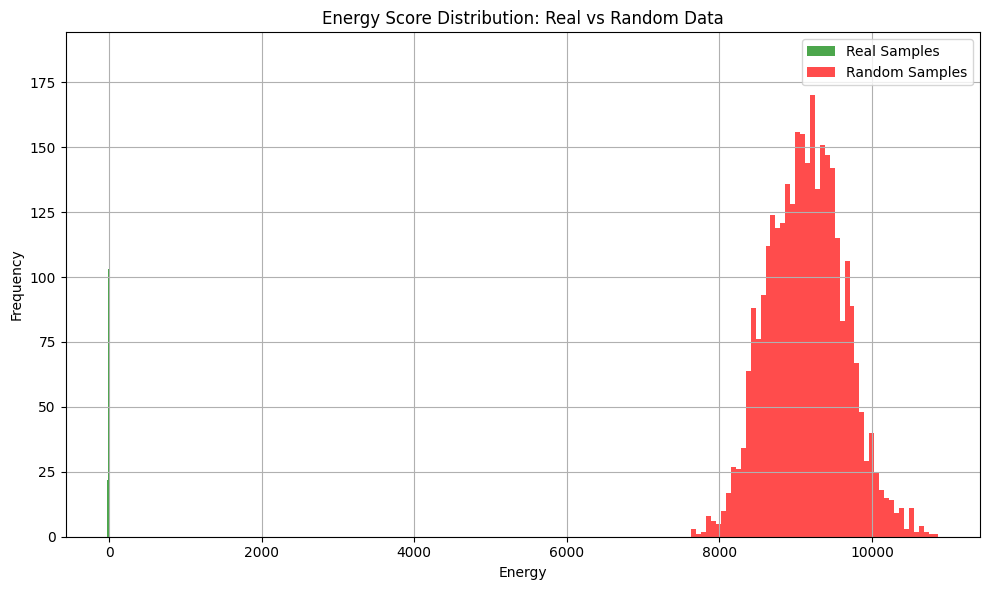

In [23]:
import matplotlib.pyplot as plt

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# Generate random samples (same shape as test set)
random_data = (torch.rand_like(X_train_tensor) * 2 - 1) * 1e-3

# Move to device
X_train_tensor = X_train_tensor.to(device)
random_data = random_data.to(device)

# Get energy scores
real_energies, _ = get_energy_scores(dagmm_model, X_train_tensor)
random_energies, _ = get_energy_scores(dagmm_model, random_data)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(real_energies, bins=50, alpha=0.7, label='Real Samples', color='green')
plt.hist(random_energies, bins=50, alpha=0.7, label='Random Samples', color='red')
plt.title("Energy Score Distribution: Real vs Random Data")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

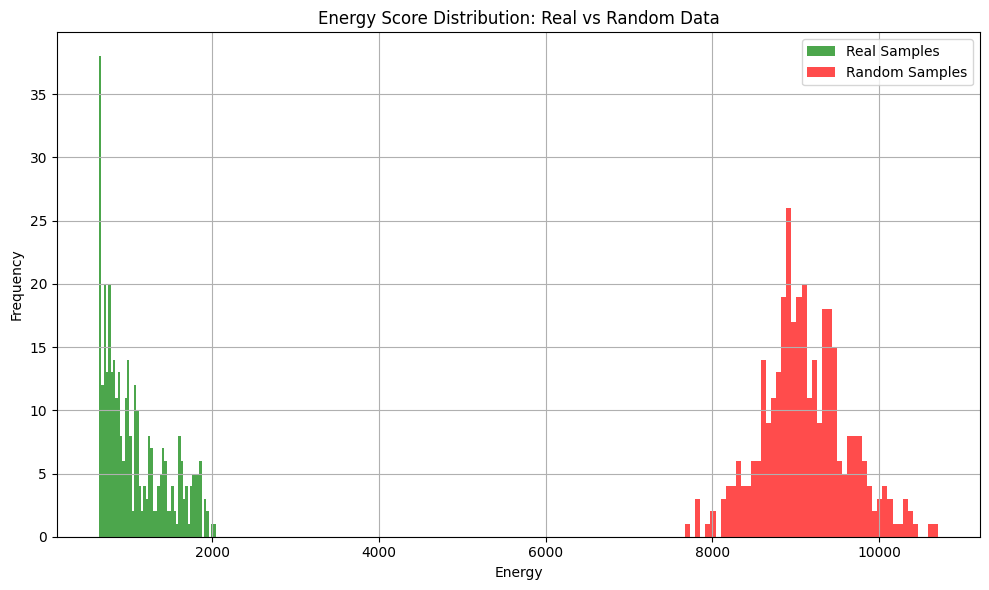

In [ ]:
import matplotlib.pyplot as plt

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# Generate random samples (same shape as test set)
random_data = (torch.rand_like(X_test_tensor) * 2 - 1) * 1e-3   # TODO always test using various 1e-3, 1e-1, 1e-4 etc.

# Move to device
X_test_tensor = X_test_tensor.to(device)
random_data = random_data.to(device)

# Get energy scores
real_energies, _ = get_energy_scores(dagmm_model, X_test_tensor)
random_energies, _ = get_energy_scores(dagmm_model, random_data)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(real_energies, bins=50, alpha=0.7, label='Real Samples', color='green')
plt.hist(random_energies, bins=50, alpha=0.7, label='Random Samples', color='red')
plt.title("Energy Score Distribution: Real vs Random Data")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_test_tensor = X_test_tensor.to(device)

energies, _ = get_energy_scores(dagmm_model, X_test_tensor)

percentile = 99
threshold_percentile = np.percentile(energies, percentile)
threshold = threshold_percentile * 1.5

print(f"\nAnomaly Threshold (at 1.5 * {percentile}th percentile of all energies): {threshold:.4f}")
print("Maximum energy: ", max(energies))


Anomaly Threshold (at 1.5 * 99th percentile of all energies): 2899.1055
Maximum energy:  2041.9757


In [43]:
import yaml
threshold_dict = {
    'dagmm_threshold': float(threshold)
}

output_yaml_path = 'dagmm_anomaly_threshold.yaml'
with open(output_yaml_path, 'w') as file:
    yaml.dump(threshold_dict, file, default_flow_style=False)

print(f"Anomaly threshold saved to '{output_yaml_path}'")

Anomaly threshold saved to 'dagmm_anomaly_threshold.yaml'


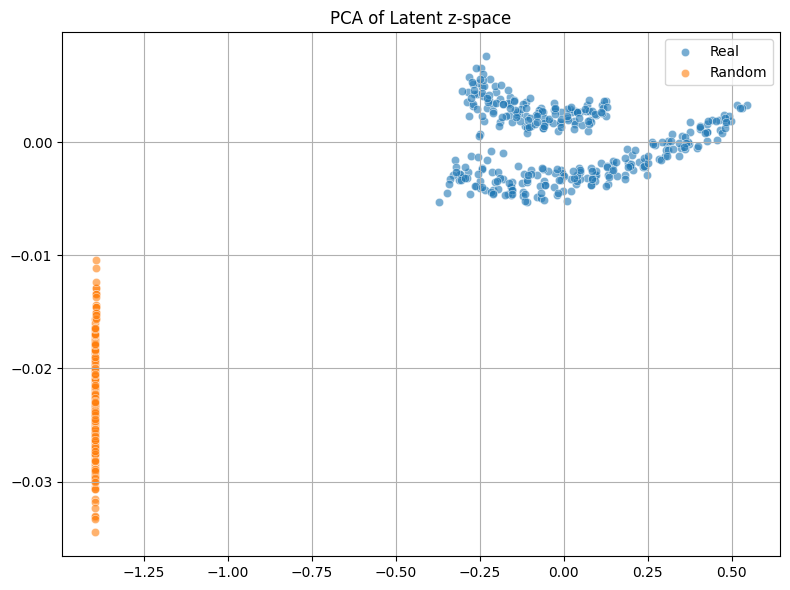

In [37]:
from sklearn.decomposition import PCA
import seaborn as sns

_, _, z_real, gamma_real = dagmm_model(X_test_tensor)
_, _, z_random, gamma_random = dagmm_model(random_data)

z_real_cpu = z_real.detach().cpu().numpy()
z_random_cpu = z_random.detach().cpu().numpy()

# Use PCA for 2D projection
pca = PCA(n_components=2)
z_real_2d = pca.fit_transform(z_real_cpu)
z_random_2d = pca.transform(z_random_cpu)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=z_real_2d[:,0], y=z_real_2d[:,1], label="Real", alpha=0.6)
sns.scatterplot(x=z_random_2d[:,0], y=z_random_2d[:,1], label="Random", alpha=0.6)
plt.title("PCA of Latent z-space")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()